In [16]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
import joblib
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [17]:
SEED = 42
n_splits = 5

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.impute import SimpleImputer
import random

train = pd.read_csv('edunet-project-dataset/train.csv')
test = pd.read_csv('edunet-project-dataset/test.csv')
sample = pd.read_csv('edunet-project-dataset/sample_submission.csv')

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df
        
train_ts = load_time_series("edunet-project-dataset/series_train.parquet")
test_ts = load_time_series("edunet-project-dataset/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)   

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

# --- REDUCE CLASSES: Merge 3 (Severe) into 2 (Moderate) -> "High Risk" ---
print(f"Original Class Counts:\n{train['sii'].value_counts()}")
train['sii'] = train['sii'].replace(3, 2)
print(f"New Class Counts (3 Classes):\n{train['sii'].value_counts()}")

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

all_mappings = {}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    all_mappings[col] = mapping

    # Modified lines to fix TypeError with Categorical data
    train[col] = train[col].astype(object).replace(mapping).astype(int)
    test[col] = test[col].astype(object).replace(mappingTe).astype(int)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    # UPDATED: Returns 0, 1, or 2 (3 Classes)
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1, 2))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

# --- CUSTOM OVERSAMPLING ONLY ---
def custom_oversampling(X, y, k_neighbors=5):
    """
    Applies ONLY Oversampling (SMOTE/Random) to minority classes to match the majority class.
    No undersampling is performed.
    """
    imputer = SimpleImputer(strategy='mean')
    X_filled_values = imputer.fit_transform(X)
    X_filled = pd.DataFrame(X_filled_values, columns=X.columns, index=X.index)

    X_resampled_list = []
    y_resampled_list = []
    
    counts = y.value_counts()
    target_count = counts.max() 
    
    # print(f"  Oversampling Target: {target_count} samples per class")
    
    for cls, count in counts.items():
        class_indices = y[y == cls].index
        
        # Always include original data
        X_resampled_list.append(X.loc[class_indices])
        y_resampled_list.append(y.loc[class_indices])
        
        if count < target_count:
            # OVERSAMPLE 
            X_class_filled = X_filled.loc[class_indices]
            n_needed = int(target_count - count)
            
            k = min(k_neighbors, len(X_class_filled) - 1)
            if k < 1:
                # Random Duplication
                X_new = X.loc[class_indices].sample(n_needed, replace=True, random_state=SEED)
                X_resampled_list.append(X_new)
                y_resampled_list.append(pd.Series([cls]*n_needed))
                continue
                
            nn = NearestNeighbors(n_neighbors=k+1).fit(X_class_filled)
            distances, indices = nn.kneighbors(X_class_filled)
            
            X_new_list = []
            for _ in range(n_needed):
                idx = random.randint(0, len(X_class_filled) - 1)
                base_vec = X_class_filled.iloc[idx]
                neighbor_idx = indices[idx][random.randint(1, k)]
                neighbor_vec = X_class_filled.iloc[neighbor_idx]
                
                diff = neighbor_vec - base_vec
                gap = random.random()
                new_vec = base_vec + (diff * gap)
                X_new_list.append(new_vec)
            
            X_new_df = pd.DataFrame(X_new_list, columns=X.columns)
            
            for col in X.columns:
                if pd.api.types.is_integer_dtype(X[col]) or col in cat_c:
                     X_new_df[col] = X_new_df[col].round().astype(int)
                     
            X_resampled_list.append(X_new_df)
            y_resampled_list.append(pd.Series([cls]*n_needed))
            
    X_final = pd.concat(X_resampled_list, axis=0).reset_index(drop=True)
    y_final = pd.concat(y_resampled_list, axis=0).reset_index(drop=True)
    
    return X_final, y_final

def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    # Lists to store detailed metrics
    fold_accuracies = []
    fold_precisions = []
    fold_recalls = []

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        # --- APPLY OVERSAMPLING ---
        X_train_res, y_train_res = custom_oversampling(X_train, y_train)

        model = clone(model_class)
        # Train on balanced/synthesized fold
        model.fit(X_train_res, y_train_res)

        y_train_pred = model.predict(X_train) 
        y_val_pred = model.predict(X_val)    

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        # Calculate additional metrics for this fold
        acc = accuracy_score(y_val, y_val_pred_rounded)
        prec = precision_score(y_val, y_val_pred_rounded, average='weighted', zero_division=0)
        rec = recall_score(y_val, y_val_pred_rounded, average='weighted', zero_division=0)
        
        fold_accuracies.append(acc)
        fold_precisions.append(prec)
        fold_recalls.append(rec)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - QWK: {val_kappa:.4f} | Acc: {acc:.4f} | Prec: {prec:.4f} | Rec: {rec:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")
    print(f"Mean Validation Accuracy --> {np.mean(fold_accuracies):.4f}")
    print(f"Mean Validation Precision -> {np.mean(fold_precisions):.4f}")
    print(f"Mean Validation Recall ----> {np.mean(fold_recalls):.4f}")

    # UPDATED: Optimization for 3 classes (2 Thresholds)
    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    thresholds = KappaOPtimizer.x
    
    oof_tuned = threshold_Rounder(oof_non_rounded, thresholds)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    # Calculate metrics on the tuned predictions
    tuned_acc = accuracy_score(y, oof_tuned)
    tuned_prec = precision_score(y, oof_tuned, average='weighted', zero_division=0)
    tuned_rec = recall_score(y, oof_tuned, average='weighted', zero_division=0)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")
    print(f"----> || Optimized Accuracy :: {Fore.CYAN}{Style.BRIGHT} {tuned_acc:.3f}{Style.RESET_ALL}")
    print(f"----> || Optimized Precision :: {Fore.CYAN}{Style.BRIGHT} {tuned_prec:.3f}{Style.RESET_ALL}")
    print(f"----> || Optimized Recall    :: {Fore.CYAN}{Style.BRIGHT} {tuned_rec:.3f}{Style.RESET_ALL}")
    
    print("\nClassification Report (Optimized):")
    print(classification_report(y, oof_tuned))

    fold_weights = [1.25, 1.0, 1.0, 1.0, 1.0]
    tpm = test_preds.dot(fold_weights) / np.sum(fold_weights)
    tpTuned = threshold_Rounder(tpm, thresholds)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission, thresholds

# Model parameters for LightGBM
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01  # Increased from 2.68e-06
}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED
}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 10  # Increase this value
}

# Create model instances
Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

# Combine models using Voting Regressor
model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
])

# Train the ensemble model
Submission2, thresholds = TrainML(model, test)

# Save submission
Submission2.to_csv('submission.csv', index=False)
print('Submission saved to submission.csv')

# Retrain and Save Model
print("Retraining model on full dataset (OVERSAMPLING Applied)...")

X = train.drop(['sii'], axis=1)
y = train['sii']

# --- APPLY OVERSAMPLING TO FULL DATASET ---
X_bal, y_bal = custom_oversampling(X, y)

print(f"Balanced Class Counts:\n{y_bal.value_counts()}")

model.fit(X_bal, y_bal)

print("Saving model and artifacts...")
joblib.dump(model, 'model.pkl')
joblib.dump(all_mappings, 'mappings.pkl')
joblib.dump(thresholds, 'thresholds.pkl')
joblib.dump(X_bal.columns.tolist(), 'features.pkl')  # Saving feature names
print("Model, mappings, and thresholds saved.")

  0%|          | 2/996 [00:00<06:55,  2.39it/s]

--- Model Evaluation ---

Top 20 Features:
                                   Feature  Importance
54                       SDS-SDS_Total_Raw         475
4                          CGAS-CGAS_Score         465
11                      Physical-HeartRate         459
52                       PAQ_C-PAQ_C_Total         445
12                    Physical-Systolic_BP         428
6                             Physical-BMI         412
10                   Physical-Diastolic_BP         395
7                          Physical-Height         354
8                          Physical-Weight         317
34                             BIA-BIA_BMC         297
37                             BIA-BIA_DEE         226
45                             BIA-BIA_LDM         226
40                            BIA-BIA_FFMI         219
18                              FGC-FGC_CU         207
30                              FGC-FGC_TL         202
22                             FGC-FGC_GSD         186
41                    

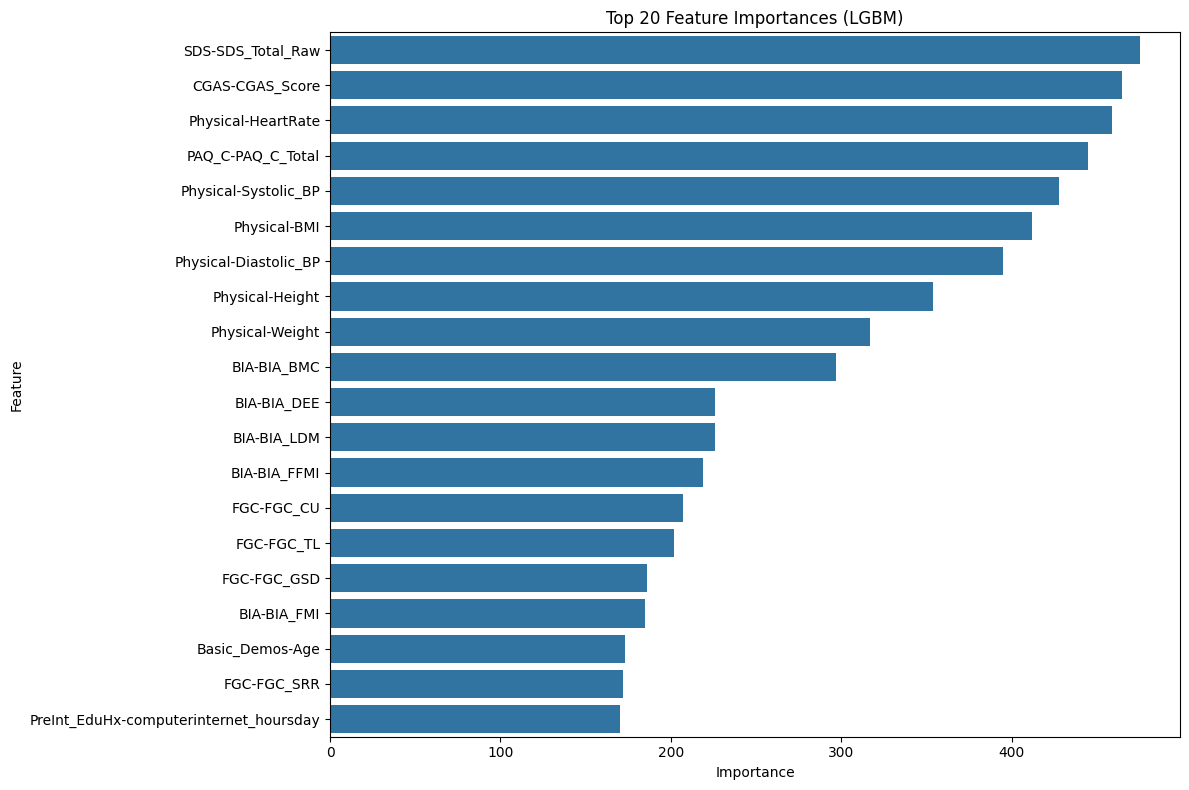

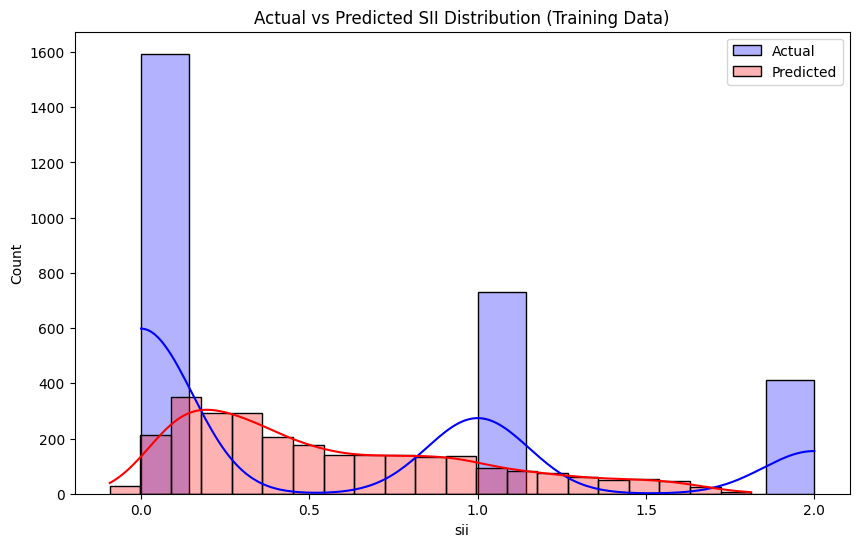


Check User Input Features in Training Data:
       Basic_Demos-Age  PreInt_EduHx-computerinternet_hoursday  Physical-BMI
count      2736.000000                             2654.000000   2527.000000
mean         10.238670                                1.015072     19.125667
std           3.427982                                1.080861      4.909305
min           5.000000                                0.000000      0.000000
25%           8.000000                                0.000000     15.773447
50%          10.000000                                1.000000     17.819010
75%          12.000000                                2.000000     21.172311
max          22.000000                                3.000000     46.102914

--- Probing Model Sensitivity (Within Notebook) ---
Varying Hours:
  Hours=0 -> Raw Score=0.3335
  Hours=5 -> Raw Score=0.8822
  Hours=10 -> Raw Score=0.8783
  Hours=15 -> Raw Score=0.8783
  Hours=20 -> Raw Score=0.8783


In [ ]:
# Evaluation and Analysis
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Model Evaluation ---")

# 1. Feature Importance
if hasattr(model, 'estimators_'):
    # LGBM is the first estimator
    lgbm_est = model.estimators_[0]
    if hasattr(lgbm_est, 'feature_importances_'):
        feature_imp = pd.DataFrame({
            'Feature': X.columns,
            'Importance': lgbm_est.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print("\nTop 20 Features:")
        print(feature_imp.head(20))
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
        plt.title('Top 20 Feature Importances (LGBM)')
        plt.tight_layout()
        plt.show()

# 2. Prediction Distribution (In-Sample)
y_pred_train = model.predict(X)
plt.figure(figsize=(10, 6))
sns.histplot(y, label='Actual', kde=True, color='blue', alpha=0.3)
sns.histplot(y_pred_train, label='Predicted', kde=True, color='red', alpha=0.3)
plt.title('Actual vs Predicted SII Distribution (Training Data)')
plt.legend()
plt.show()

# 3. Check for specific user inputs
user_cols = ['Basic_Demos-Age', 'PreInt_EduHx-computerinternet_hoursday', 'Physical-BMI']
print("\nCheck User Input Features in Training Data:")
valid_cols = [c for c in user_cols if c in X.columns]
print(X[valid_cols].describe())

# 4. Probing Sensitivity (New)
print("\n--- Probing Model Sensitivity (Within Notebook) ---")
# Create a dummy row with average values
dummy_row = X.mean().to_frame().T

# FIX: CatBoost crashes if categorical columns are floats (caused by .mean())
# We must cast them back to integers.
if 'cat_c' in globals():
    for c in cat_c:
        if c in dummy_row.columns:
            dummy_row[c] = dummy_row[c].round().astype(int)

if 'PreInt_EduHx-computerinternet_hoursday' in dummy_row.columns:
    print("Varying Hours:")
    for h in [0, 5, 10, 15, 20]:
        temp = dummy_row.copy()
        temp['PreInt_EduHx-computerinternet_hoursday'] = h
        if 'Internet_Hours_Age' in temp.columns: # Re-engineer if needed
             temp['Internet_Hours_Age'] = h * temp['Basic_Demos-Age']
        
        pred = model.predict(temp)[0]
        print(f"  Hours={h} -> Raw Score={pred:.4f}")

Optimized Thresholds: [0.69367871 0.89934025]
✅ Thresholds are strictly increasing and valid.


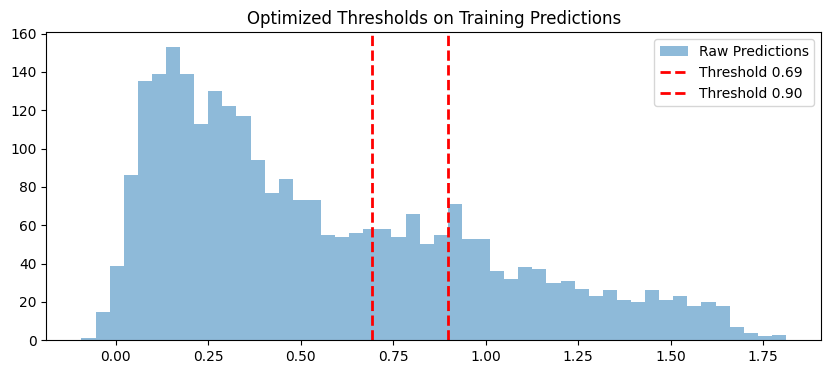

In [ ]:
print(f"Optimized Thresholds: {thresholds}")

# Check if thresholds are strictly increasing (sanity check)
if np.all(np.diff(thresholds) > 0):
    print("✅ Thresholds are strictly increasing and valid.")
else:
    print("⚠️ Warning: Thresholds are not strictly increasing. Optimization might be unstable.")

# Visualize where these thresholds fall
plt.figure(figsize=(10, 4))
plt.hist(model.predict(X), bins=50, alpha=0.5, label='Raw Predictions')
for th in thresholds:
    plt.axvline(th, color='r', linestyle='--', linewidth=2, label=f'Threshold {th:.2f}')
plt.title('Optimized Thresholds on Training Predictions')
plt.legend()
plt.show()

In [ ]:
print("--- Statistics for New UI Inputs ---")
cols_to_check = ['Physical-HeartRate', 'SDS-SDS_Total_Raw', 'PAQ_C-PAQ_C_Total']
print(X[cols_to_check].describe())

--- Statistics for New UI Inputs ---
       Physical-HeartRate  SDS-SDS_Total_Raw  PAQ_C-PAQ_C_Total
count         2486.000000        2527.000000        1440.000000
mean            81.823411          40.977839           2.590608
std             13.769816          10.231384           0.786610
min             27.000000          17.000000           0.580000
25%             73.000000          33.000000           2.020000
50%             81.000000          39.000000           2.550000
75%             91.000000          46.000000           3.160000
max            138.000000          96.000000           4.790000
